# Can a machine learning program distringuish German speakers from Swedish speakers?

>You can spot an Irishman or a Yorkshireman by his brogue. I can place any man within six miles. I can place him within two miles in London. Sometimes within two streets.
- Henry Higgins, in <em>Pygmalion</em>, by George Bernard Shaw

Using a custom dataset scraped from hundreds of audio files, we attempt to determine whether spectrograms of Swedish and German conversations (both male and femals) can be distinguished by machine learning algorithms, or else, maybe ML can at least distinguish between male and female voices.

We know ML can distinguish bird calls by looking at spectrograms, but spectrograms of conversational streams of two fairly closely related languages will presumably be harder to distinguish. 

<b>The short answer is that it does pretty well -- around 85% accuracy given a dataset of about 150 distinct 10-second .wav files from each language. Am I certain of this? No, there could be flaws in the design of the dataset as indicated below, but this seems a good start.</b>

Numerous companies that have thousands of "this call may be recorded for training purposes..." messages in databases would very much like to have a good guess of the caller's age, gender, regional dialect and so forth even before they fill out any forms. If you're interested in forming a startup to that end, or helping your company do something similar, please credit (and/or hire) me. For this study, the dataset consists of snippets of Swedish and German conversation, 10-11 seconds in length, taken from interviews, news broadcasts and other video clips (and recorded in mono with Audacity). Perhaps, by the time you read this, some other languages have been added. You can just delete the directories of the other languages, if you wish to replicate what I've done here

For those attempting something similar, here are some takeaways I hope will prove useful.

- I obtained significantly better results with 150 files in each language than with just 100 files. While some ML programs can do a lot with a relatively small number of samples, this is one where a larger dataset seems preferable, though the final size of this was was over 300 megabytes, and I did not want to run into any Kaggle limits.

- I obtained better results with a MEL spectrogram than with a standard spectrogram (i.e. my first choice). This is not particularly surprising given that the frequency scaling in the former allows us to focus on frequency ranges similar to that of the human ear. Note the MEL sectrograms take significantly longer to generate.

- I obtained slightly better results by using a 'Magma' color map on my spectrograms than I obtained with 'Rainbow'. That is a little surprising, and perhaps spurious -- I did not spend a lot of time  with this, so maybe any improvement was just a fluke of the runs I encountered, but comparing different color maps may halp someone else improve their spectrogram analyses.

- I tried various ways of scaling or chunking the data (e.g. ignoring frequencies above a certain cutoff, splitting the 10-second wav files into 5-second wave files -- note I was careful in that case to make sure that a given speaker's files were all put into the training directory or else they all went into validation directory -- or else randomly choosing a snippet of speech but it did not improve my results.

- Surprisingly, I did <b>not</b> get better results when I tried to distinguish German and French files than was the case for German and Swedish files, even though the former two languages sound far more dissimilar to my ear than the latter. There are all sorts of reasons why this could be the case. As I recall, French is a difficult language to lip-read, and  at the risk of offending Francophones, outside listeners typically regard French to be more "slurred" than other European lanaguages, so maybe Spanish or Italian would have been a language more suited to this analysis. However, this surprising result may also indicate the program is focusing on something other than voices as it distinguishes different speaking styles.

Most importantly, this was a good training exercise. I got to stress over what it means to have a good dataset (using lots of different sources with hopefull similar recording techniques for all the languages). I learned how to use custom splitters, custom data-augmetation routines, the finer points of color maps and stripping tick marks from graphs before feeding (though I left the reference comlor map bar in the final set of runs). I suspect in the real world, data gethering and scrubbing and filtering is a bigger hassle than the actual machine learning.

All the data files were also identified by gender. Unsurprisingly, the approach here works even better at the simpler task of distinguishing male and female voices.

In [1]:
## Converting .wav files to spectrograms
### ( using https://dolby.io/blog/beginners-guide-to-visualizing-audio-as-a-spectogram-in-python/)

NOTE: You may be asked for both your Kaggle name and your Kaggle key (or else, by the time anyone else reads this, some new protocol will be in place, in which case, appreciate the fact that I at least tried to help walk you through this).
    
If you go to your Kaggle account and look at the URL it will be the
portion between the '/' characters that follows 'kaggle.com'. As for the
key, you must generate and download an API key (see the API section on your account page -- i.e. the button that says 'Create New API Token'), then open the file with a text browser (e.g. Notepad++ or TextEdit, depending on your OS) and then copy the "key" value in the dictionary
you see defined there -- note the file also contains the username.

In [2]:
import os 
import shutil

# for data transformation
import numpy as np
# for visualizing the data
import matplotlib.pyplot as plt
# for opening the media file
import scipy.io.wavfile as wavfile

In [3]:
!pip install opendatasets;

In [4]:
import opendatasets as od
import shutil
bFrench = False
if bFrench:
    od.download("https://www.kaggle.com/datasets/hjhrgov/largergermanswedish10secconversationalwavfiles", force=True)
    thisDirectiory = "/kaggle/working/largergermanswedish10secconversationalwavfiles/ML_speech_recognition"
    langList = ['german', 'swedish', 'french']
    os.chdir(thisDirectiory)
    # get rid of Swedish (if you want)
    #shutil.rmtree("/kaggle/working/largergermanswedish10secconversationalwavfiles/ML_speech_recognition/swedish")
else:
    od.download("https://www.kaggle.com/datasets/hjhrgov/largergermanswedish10secconversationalwavfiles", force=True)
    thisDirectiory = "/kaggle/working/largergermanswedish10secconversationalwavfiles/ML_speech_recognition"
    langList = ['german', 'swedish']
    shutil.rmtree("/kaggle/working/largergermanswedish10secconversationalwavfiles/ML_speech_recognition/french")
    os.chdir(thisDirectiory)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  hjhrgov


Your Kaggle Key:

  ································


100%|██████████| 330M/330M [00:02<00:00, 149MB/s]  


In [5]:
#!ls ./*/*.wav
#shutil.rmtree("/kaggle/working/largergermanswedish10secconversationalwavfiles/ML_speech_recognition/images")

In [6]:
#sorry, but one file needs to be renamed if we choose to distinguish male and female spakers since
#the usual naming convention was violated

!mv ./german/F20221216RicardaLang.wav ./german/F_20221216RicardaLang.wav

In [7]:
langList

['german', 'swedish']

In [8]:
import glob
fList = glob.glob('./*/*.wav')

# all files are between 10 and 11 seconds long, so we'll trim them all to 10 seconds
print(fList)
nSseconds = 10
wavFName = fList[62]

print(fList)

Fs, aud = wavfile.read(wavFName)

# our files are in mono, so we can delete the follwing
  # select left channel only
  #aud = aud[:,0]

# trim the files to the desired number of seconds
first = aud[:int(Fs*nSseconds)]
first.shape

['./german/M_20220721TimSpierssberger.wav', './german/M_20220605AndreasAudrecht.wav', './german/F_20221013SophieSchonberger.wav', './german/F_20221229AnnetteHilsenbeck.wav', './german/F_20221026LeonoreGewessler.wav', './german/M_MarkusLanz.wav', './german/M_20190414HeinzBude.wav', './german/F_20221010PatriciaWiedermeyer.wav', './german/M_20220523AlexanderGerst.wav', './german/F_20230117EvaHogl.wav', './german/F_20221010JuliaWillieHamburg.wav', './german/F_20230118SabineMertens.wav', './german/M_KlausKinski.wav', './german/M_RogerFederer.wav', './german/F_InesPohl.wav', './german/M_PhilippHubl.wav', './german/M_20220605FredEickhorst.wav', './german/M_20220519JohannesHano.wav', './german/F_20221001FrederikeHofmann.wav', './german/F_20230118AnjaKohl.wav', './german/M_20220615JosefSchuster.wav', './german/M_20190414MichelFriedman.wav', './german/F_20221123AgnieszkaBrugger.wav', './german/M_20220523KarlLarsWagner.wav', './german/M_20221001CemOzdemir.wav', './german/M_20230118MichaelGrytz.wa

(441000,)

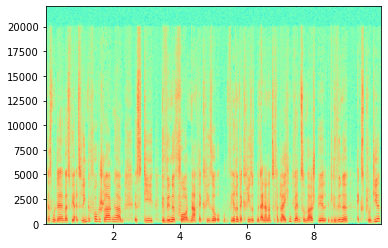

In [9]:
nfft = 1024
powerSpectrum, frequenciesFound, time, imageAxis = plt.specgram(first, Fs=Fs,  NFFT=nfft, mode='psd',cmap='rainbow')
#plt.show()

pngName = wavFName[:-3] + 'png'
pngNameExtra = ("./" + pngName[2:]) 

plt.savefig(pngNameExtra) 

We shall delete any ticks or other markings, in case we need to use data augmentation that crops and magnifies portions of our image files.


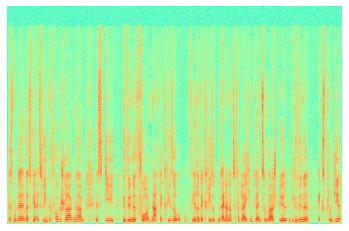

In [10]:
powerSpectrum, frequenciesFound, time, imageAxis = plt.specgram(first, Fs=Fs,  NFFT=nfft, mode='psd',cmap='rainbow')
#plt.show()

pngName = wavFName[:-3] + 'png'
# we remove axis, tick marks, frame -- everything but spectrogram itself
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.savefig("./" + pngName[2:]) 

After playing with the parameters, it seems that the NFFT arg should be larger than the default of 256, and once we set it to 1024 or higher, we see the nice wood-grain feature at the bottom of the axis that many associate with sound spectrograms. Moreover, that bottom seems to be the most interesting portion. So, let's try to limit the spectrum to 6k or 7k, initially.

./german/F_20220605GesineLotzsch.png


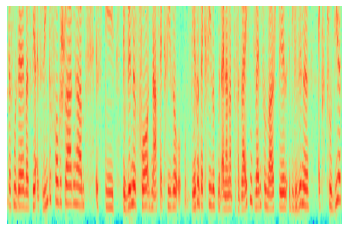

In [11]:
import matplotlib.mlab as mlab

# modified specgram()
# see https://stackoverflow.com/questions/19468923/cutting-of-unused-frequencies-in-specgram-matplotlib
max_freq = 2500 # 500 * 1000 # 4000 # 2500 #1500 # 8000



def my_specgram(x, NFFT=256, Fs=2, Fc=0, detrend=mlab.detrend_none,
             window=mlab.window_hanning, noverlap=128,
             cmap=None, xextent=None, pad_to=None, sides='default',
             scale_by_freq=None, minfreq = None, maxfreq = None, **kwargs):
    """
    call signature::

      specgram(x, NFFT=256, Fs=2, Fc=0, detrend=mlab.detrend_none,
               window=mlab.window_hanning, noverlap=128,
               cmap=None, xextent=None, pad_to=None, sides='default',
               scale_by_freq=None, minfreq = None, maxfreq = None, **kwargs)

    Compute a spectrogram of data in *x*.  Data are split into
    *NFFT* length segments and the PSD of each section is
    computed.  The windowing function *window* is applied to each
    segment, and the amount of overlap of each segment is
    specified with *noverlap*.

    %(PSD)s

      *Fc*: integer
        The center frequency of *x* (defaults to 0), which offsets
        the y extents of the plot to reflect the frequency range used
        when a signal is acquired and then filtered and downsampled to
        baseband.

      *cmap*:
        A :class:`matplotlib.cm.Colormap` instance; if *None* use
        default determined by rc

      *xextent*:
        The image extent along the x-axis. xextent = (xmin,xmax)
        The default is (0,max(bins)), where bins is the return
        value from :func:`mlab.specgram`

      *minfreq, maxfreq*
        Limits y-axis. Both required

      *kwargs*:

        Additional kwargs are passed on to imshow which makes the
        specgram image

      Return value is (*Pxx*, *freqs*, *bins*, *im*):

      - *bins* are the time points the spectrogram is calculated over
      - *freqs* is an array of frequencies
      - *Pxx* is a len(times) x len(freqs) array of power
      - *im* is a :class:`matplotlib.image.AxesImage` instance

    Note: If *x* is real (i.e. non-complex), only the positive
    spectrum is shown.  If *x* is complex, both positive and
    negative parts of the spectrum are shown.  This can be
    overridden using the *sides* keyword argument.

    **Example:**

    .. plot:: mpl_examples/pylab_examples/specgram_demo.py

    """

    #####################################
    # modified  axes.specgram() to limit
    # the frequencies plotted
    #####################################

    # this will fail if there isn't a current axis in the global scope
    ax = plt.gca()
    Pxx, freqs, bins = mlab.specgram(x, NFFT, Fs, detrend,
         window, noverlap, pad_to, sides, scale_by_freq)

    # modified here
    #####################################
    if minfreq is not None and maxfreq is not None:
        Pxx = Pxx[(freqs >= minfreq) & (freqs <= maxfreq)]
        freqs = freqs[(freqs >= minfreq) & (freqs <= maxfreq)]
    #####################################
    
    if False:
        # let's also make the higher frequencies less dense
        # replacing them with an average over several nearby frequencies
        #####################################
        newfreqs = []
        #print(freqs.type)

        #import pdb; pdb.set_trace()
        i_prevfreq = -1
        for iifreq, ifreq in enumerate(list(freqs)):
            if ifreq <= 2000:
                newfreqs.append(ifreq)
                i_prevfreq = iifreq
            elif ifreq <= 4000:
                spacing = 2
                if iifreq - i_prevfreq >= spacing:
                    meanfreq = np.sum(freqs[(iifreq - spacing):iifreq])/float(spacing)
                    newfreqs.append(meanfreq)
                    i_prevfreq = iifreq
            elif ifreq < 8000:
                spacing = 4
                if iifreq - i_prevfreq >= spacing:
                    meanfreq = np.sum(freqs[(iifreq - spacing):iifreq])/float(spacing)
                    newfreqs.append(meanfreq)
                    i_prevfreq = iifreq  
            elif ifreq < 16000:
                spacing = 8
                if iifreq - i_prevfreq >= spacing:
                    meanfreq = np.sum(freqs[(iifreq - spacing):iifreq])/float(spacing)
                    newfreqs.append(meanfreq)
                    i_prevfreq = iifreq   
            else:
                spacing = 16
                if iifreq - i_prevfreq >= spacing:
                    meanfreq = np.sum(freqs[(iifreq - spacing):iifreq])/float(spacing)
                    newfreqs.append(meanfreq)
                    i_prevfreq = iifreq 

        freqs = np.array(newfreqs)
        #####################################
    
    
    
    

    Z = 10. * np.log10(Pxx)
    Z = np.flipud(Z)

    if xextent is None: xextent = 0, np.amax(bins)
    xmin, xmax = xextent
    freqs += Fc
    extent = xmin, xmax, freqs[0], freqs[-1]
    
    
    # I modify the stackoverflow answer to remove ticks and axis
    ax.axis('auto')
    #plt.cla()
    #plt.clf()
    #plt.close()


    im = ax.imshow(Z, cmap, extent=extent, **kwargs)
    
    
    return Pxx, freqs, bins, im

# plot
#ax1 = plt.plot()

# the minfreq and maxfreq args will limit the frequencies 
Pxx, freqs, time, imageAxis = my_specgram(first,nfft, Fs, noverlap=128, 
                                cmap="rainbow", minfreq = 0, maxfreq = max_freq)
# strip off everything but spectrogram itself
plt.axis('auto')
#plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.savefig(pngNameExtra)
#plt.show()
print(pngNameExtra)


In [12]:
print(pngName)



./german/F_20220605GesineLotzsch.png


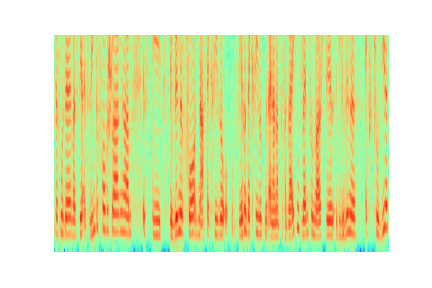

In [13]:
#os.chdir("./")
import IPython
IPython.display.Image(pngNameExtra)

That looks good, but spoiler alert: the results are pretty bad (i.e. an error-rate of about 30%). A better way to focus on the interesting portions of the spectrogram is to use a MELspectrogram, which scales the frequency spectrum in a way that more in line with how the human ear perceives sound, and therefore, it is a better candidate for speech that is targeted to human ears.

In [14]:
# The code below is kept only for future reference -- for now,
# let's forcus on MEL spectrograms as noted above

# delete any other image files that might be present
# from some previous run with some other maximum frequency
if False:
    bDeletePrevImageFiles = False
    if bDeletePrevImageFiles:
        fList = glob.glob('./*/*.png')
        if len(fList) > 0:
            print("Removing " + str(len(fList)) + " existing image files.")
        for iFile in fList:
            os.remove(iFile)

    for i_lang in langList:
        i_iter = 0
        fList = glob.glob('./' + i_lang + '/*.wav')
        print("we have", len(fList), i_lang, "files.")
        N_langbatch = len(fList)
        if len(glob.glob('./' + i_lang + '/*.wav')) == 0:
            print("WARNING: zero files found corresponding to ./ML_speech_recognition/" + i_lang + "/*.wav")
            continue

        for wavfname in fList:

            try:
                Fs, aud = wavfile.read(wavfname)
            except:
                print("Could not read " + wavfname)
            if i_iter % 10 == 0:
                print("Working on the " + i_lang + " files and processing file " + str(i_iter) + " out of " + str(N_langbatch))
            i_iter += 1
            # trim the files to the desired number of seconds
            first = aud[:int(Fs*nSseconds)]
            first.shape
            #powerSpectrum, frequenciesFound, time, imageAxis = plt.specgram(first, Fs=Fs)
            #plt.show()
            pngName = wavfname[:-3] + 'png'
            powerSpectrum, frequenciesFound, time, imageAxis = my_specgram(first, nfft, Fs, 128, 
                                    cmap="rainbow", minfreq = 0, maxfreq = max_freq)


            #plt.axis('off')

            #plt.show(imageAxis)
            #plt.savefig(pngname) #save as png
            #plt.clear()



            plt.axis('auto')
            #plt.axis('off')
            plt.xticks([])
            plt.yticks([])
            plt.axis('off')

            gc = plt.gcf()
            gc.savefig(pngName)
            #plt.show(); 
            #print(wavfname)
            plt.close()
            #img = matplotlib.image.imread(pngname)
            #plt.imshow(img)
            #plt.cla()
            #plt.clf()
            plt.close()

            #if i_iter > 2:
            #    break


        print("completed " + i_lang + " files")

In [15]:
fList = glob.glob('./*/*.png') 
len(fList)

1

In [16]:
CMAP = 'magma'

22050


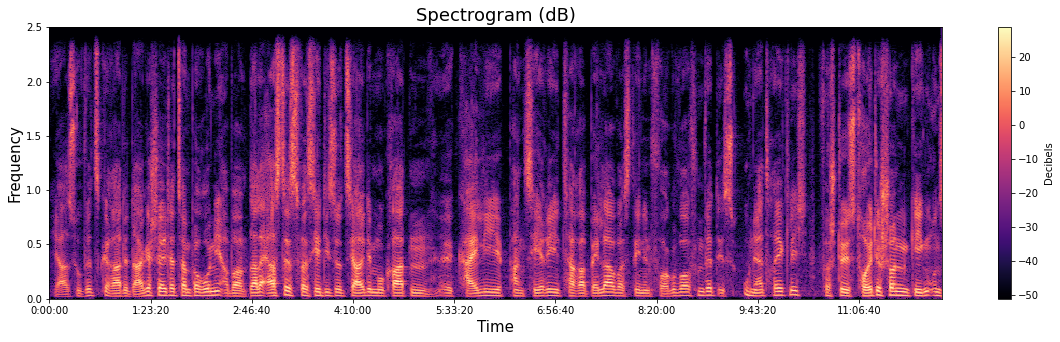

In [17]:
import librosa, librosa.display
#https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53
#https://importchris.medium.com/how-to-create-understand-mel-spectrograms-ff7634991056

signal, sr = librosa.load(librosa.util.example('brahms'))
signal, sr = librosa.load('./german/M_20230118DanielCaspary.wav')

signal = signal[:int(441000/2)]

print(sr)
#signal = first
my_hop_length = 128

if True:
# Short-time Fourier Transformation on our audio data

    audio_stft = librosa.core.stft(signal, hop_length=my_hop_length, n_fft=nfft)
    # gathering the absolute values for all values in our audio_stft 
    spectrogram = np.abs(audio_stft)
    # Converting the amplitude to decibels
    log_spectro = librosa.amplitude_to_db(spectrogram)
    # Plotting the short-time Fourier Transformation
    plt.figure(figsize=(20, 5))
    # Using librosa.display.specshow() to create our spectrogram
    librosa.display.specshow(log_spectro, sr=5, x_axis='time', y_axis='hz', hop_length=my_hop_length, cmap=CMAP)
    plt.colorbar(label='Decibels')
    plt.title('Spectrogram (dB)', fontdict=dict(size=18))
    plt.xlabel('Time', fontdict=dict(size=15))
    plt.ylabel('Frequency', fontdict=dict(size=15))
    plt.show()

In [18]:
#shutil.rmtree(os.getcwd() + '/images')

In [19]:
 if True:
    bDeletePrevImageFiles = False
    if bDeletePrevImageFiles:
        fList = glob.glob('./*/*.png')
        if len(fList) > 0:
            print("Removing " + str(len(fList)) + " existing image files.")
        for iFile in fList:
            os.remove(iFile)

    for i_lang in langList:
        i_iter = 0
        fList = glob.glob('./' + i_lang + '/*.wav')
        N_langbatch = len(fList)
        print("we have", len(fList), i_lang, "files.")
        if len(glob.glob('./' + i_lang + '/*.wav')) == 0:
            print("WARNING: zero files found corresponding to ./ML_speech_recognition/" + i_lang + "/*.wav")
            continue

        for wavfname in fList:

            try:
                Fs, aud = wavfile.read(wavfname)
            except:
                print("Could not read " + wavfname)
            if i_iter % 10 == 0:
                print("Working on the " + i_lang + " files and processing file " + str(i_iter) + " out of " + str(N_langbatch))
            i_iter += 1
            
            #------------
            # trim the files to the desired number of seconds
            #first = aud[:int(Fs*nSseconds)]
            #first.shape
            #powerSpectrum, frequenciesFound, time, imageAxis = plt.specgram(first, Fs=Fs)
            #plt.show()
            pngName = wavfname[:-3] + 'png'
            #powerSpectrum, frequenciesFound, time, imageAxis = my_specgram(first, nfft, Fs, 128, 
            #                        cmap="rainbow", minfreq = 0, maxfreq = max_freq)
            #------------
            signal, sr = librosa.load(wavfname)
            
            # adjust for mono
            signal = signal[:int(441000/2)]            
            audio_stft = librosa.core.stft(signal, hop_length=my_hop_length, n_fft=nfft)
            # gathering the absolute values for all values in our audio_stft 
            spectrogram = np.abs(audio_stft)
            # Converting the amplitude to decibels
            log_spectro = librosa.amplitude_to_db(spectrogram)
            # Plotting the short-time Fourier Transformation
            plt.figure(figsize=(20, 5))
            # Using librosa.display.specshow() to create our spectrogram
            librosa.display.specshow(log_spectro, sr=5, x_axis='time', y_axis='hz', hop_length=my_hop_length, cmap=CMAP)
            plt.colorbar(label='Decibels')
            #plt.title('Spectrogram (dB)', fontdict=dict(size=18))
            #plt.xlabel('Time', fontdict=dict(size=15))
            #plt.ylabel('Frequency', fontdict=dict(size=15))
            plt.title('', fontdict=dict(size=18))
            plt.xlabel('', fontdict=dict(size=15))
            plt.ylabel('', fontdict=dict(size=15))
                     
            #------------

            #plt.axis('off')

            #plt.show(imageAxis)
            #plt.savefig(pngname) #save as png
            #plt.clear()



            plt.axis('auto')
            #plt.axis('off')
            plt.xticks([])
            plt.yticks([])
            plt.axis('off')

            gc = plt.gcf()
            gc.savefig(pngName)
            #plt.show(); 
            #print(wavfname)
            plt.close()
            #img = matplotlib.image.imread(pngname)
            #plt.imshow(img)
            #plt.cla()
            #plt.clf()
            plt.close()

            #if i_iter > 2:
            #    break


        print("completed " + i_lang + " files")

we have 167 german files.
Working on the german files and processing file 0 out of 167
Working on the german files and processing file 10 out of 167
Working on the german files and processing file 20 out of 167
Working on the german files and processing file 30 out of 167
Working on the german files and processing file 40 out of 167
Working on the german files and processing file 50 out of 167
Working on the german files and processing file 60 out of 167
Working on the german files and processing file 70 out of 167
Working on the german files and processing file 80 out of 167
Working on the german files and processing file 90 out of 167
Working on the german files and processing file 100 out of 167
Working on the german files and processing file 110 out of 167
Working on the german files and processing file 120 out of 167
Working on the german files and processing file 130 out of 167
Working on the german files and processing file 140 out of 167
Working on the german files and processi

12
./german/M_20230118AlexanderStenzel.png


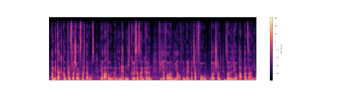

In [20]:
from PIL import Image

fList = glob.glob('./*/*.png') + glob.glob('./*/*/*.png')

whichFile = np.random.randint(0, len(fList))
import matplotlib.image as mpimg

img = mpimg.imread(fList[whichFile])
#plt.axis('auto')
plt.axis('off')
#plt.xticks([])
#plt.yticks([])
#plt.axis('off')

#plt.show()
#print(pngName)
plt.imshow(img)

print(whichFile)
print(fList[whichFile])

In [21]:
# now that we have some data files, let us move on to fastai
# what follows has been adapted from Jeremy Howard's "Is it a bird?"
# notebook
!pip install -Uqq fastai 

In [22]:
# we will need to modify the file names to include the language spoken 
# since it is easiest to dump all the image files into one directory
flist = glob.glob('./*/*.png')
for ifile in flist:
    ifilechunks = ifile.split('/')
    lang = ifilechunks[-2]
    newfname = '/'.join(ifilechunks[:-1]) + '/' + lang + '_' + ifilechunks[-1]
    os.rename(ifile, newfname)


In [23]:
fList = glob.glob('./*/*.png')
nFilesBeforeMove = len(fList)
print(nFilesBeforeMove)

334


In [24]:
#fList

In [25]:
!ls -lt .

import shutil
newDir = '.' + '/images'

if not(os.path.exists(newDir)):
    os.makedirs(newDir)

fList = glob.glob('./*/*.png')  # note previous fnames is no longer valid
for ifile in fList:
    newfile = newDir + '/' + ifile.split('/')[-1]
    shutil.move(ifile, newfile)
    


total 88
drwxr-xr-x 2 root root 20480 Feb  1 02:46 swedish
drwxr-xr-x 2 root root 28672 Feb  1 02:46 german
-rw-r--r-- 1 root root 28856 Feb  1 02:39 credits.txt


In [26]:
#!ls -lt ./images/*

In [27]:
fList = glob.glob('./*/*.png')
nFilesAfterMove = len(fList)
print(nFilesAfterMove)

334


In [28]:
if nFilesAfterMove != nFilesBeforeMove:
    print("Apparently some files got lost during the extraction\nfrom the separate language directories to the single 'image' directory. You need to find out what went wrong, and rerun...")

In [29]:
!pip install -Uqq fastbook

In [30]:
import fastbook 
fastbook.__version__

'0.0.29'

In [31]:
from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *

In [32]:
# some deprecated code that might prove useful to someone so I will leave it
#dblock = DataBlock()
#dsets = dblock.datasets(fnames)

In [33]:

bIgnoreMFSubclasses = True # if false, then male and female speakers 
                           #. of any language will be a separate class
def label_func(fname):
    #return "cat" if fname.name[0].isupper() else "dog"
    #print(fname.name)
    #return
    chunks = fname.name.split('/')
    subchunks = chunks[-1].split('_')
    if bIgnoreMFSubclasses:
        return subchunks[0]
    else:
        return '_'.join(subchunks[:2])

In [34]:
# an easier task is distinguishing male voices from female voices
# if you wish to try that, change the name of this function from 
# label_funcMF to label_func, thereby overriding the above definition.
# In that case, I was able to get the error rate down to 50% with just
# two hundred wav files
def label_funcMF(fname):
    #return "cat" if fname.name[0].isupper() else "dog"
    #print(fname.name)
    #return
    chunks = fname.name.split('/')
    subchunks = chunks[-1].split('_')
    if bIgnoreMFSubclasses:
        return subchunks[1] #'_'.join(subchunks[0:2])

In [35]:
# again, I will leave this here just in case it proves useful
#dblock = DataBlock(get_items = get_image_files, get_y = label_func)

In [36]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func)

In [37]:
path = './'
dsets = dblock.datasets(path + "images")

In [38]:
# let's peek in to what we have in our dataset
len(dsets.train)

268

In [39]:
dsets.vocab

['german', 'swedish']

In [40]:
# here's a snapshot of one validation image

ORIGSHAPE = dsets.valid[0][0].shape
dsets.valid[0][0]
print(ORIGSHAPE)


(360, 1440)


In [41]:
#dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
#                   get_items = get_image_files,
#                   get_y     = label_func,
#                   splitter  = RandomSplitter())

(360, 1440)
(360, 1440)


<AxesSubplot:>

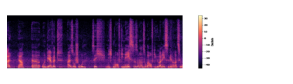

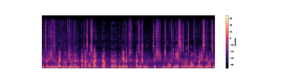

In [42]:
# the following takes a segment xMin of the spectrogram (at least 0.5 of the orig length)
# shose start can anywhere from 0 to xLen - xMin
# and then stretches the crop horizontally to the original lengthxLen

# Any other basic crop is likely inappropriate

from copy import copy
from PIL import Image

def RandomHorizontalCrop(rawimg):
    
    if torch.is_tensor(rawimg):
        return rawimg
    else:
        img = rawimg
    origsize = img.shape
    #if len(origsize) != 2:
    #    print("holdon ", origsize)
    r1 = np.random.rand()
    r2 = np.random.rand()
    #print(r1, r2)
    #print(origsize)
    MINXCROP = 0.5
    MINXCROP = np.min((np.max((0, MINXCROP)), 1.0))
    Xcrop = np.round(((MINXCROP +  (1.0 - MINXCROP) * r1) * origsize[1]))
    Xcrop = np.min((origsize[1], Xcrop))  
    Xbegin = r2 * (origsize[1] - Xcrop)
    Xbegin = np.max((0, origsize[1] - Xcrop))
    box=(Xbegin, 0, np.min((origsize[1], Xbegin + Xcrop)), origsize[0])
    #img
    newimg = img.crop(box)
    #newimg.show()
    newimg = newimg.resize((origsize[1], origsize[0]))
    #newimgarr = np.asarray(newimg)
    #newimg = Image.fromarray(newimgarr)
    #?newimg
    #return newimg

    np_img = np.array(newimg)
    #aug_img = aug(image=np_img)['image']
    return PILImage.create(np_img)   


testimg = './images/german_M_20220517CorneliusMeyerHort.png'
rawimg = PILImage.create(testimg)
#print(np.asarray(rawimg)[:3])
#?rawimg
img = RandomHorizontalCrop(rawimg)

print(rawimg.shape)
print(img.shape)
#?img
#rawimg.show()
img.show()
rawimg.show()

In [43]:
bCustomTransform = False # if true, then your transforms/data-augmentation includes the custom function defined above

if bCustomTransform:
    my_item_tfms = [Resize(224), RandomHorizontalCrop]
    dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func,
                   splitter  = RandomSplitter(),
                   #item_tfms = Resize(224)
                   #batch_tfms=aug_transforms()
                   #tfms = None) 
                   item_tfms = my_item_tfms)
else:

    dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func,
                   splitter  = RandomSplitter(),
                   item_tfms = Resize(224,method=ResizeMethod.Squish))

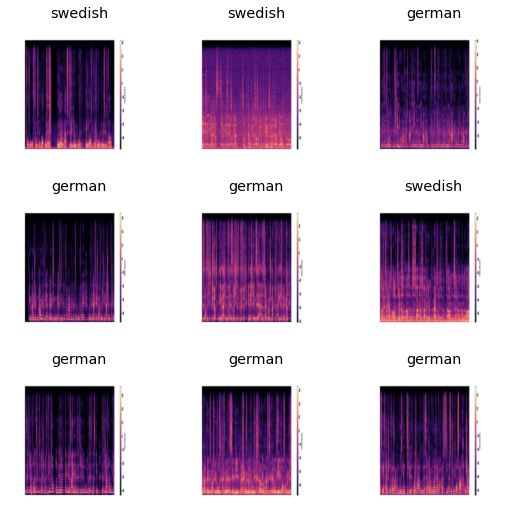

In [44]:
dls = dblock.dataloaders(path + "images")
dls.show_batch()

In [45]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(18)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.299989,2.156724,0.515152,00:25


epoch,train_loss,valid_loss,error_rate,time
0,0.596121,0.705374,0.348485,00:38
1,0.485045,0.637037,0.272727,00:37
2,0.386271,0.608407,0.318182,00:33
3,0.319265,0.616298,0.303030,00:31
4,0.254486,0.670610,0.257576,00:31
5,0.210403,0.736717,0.227273,00:33
6,0.174291,0.810241,0.212121,00:31
7,0.147437,0.799067,0.212121,00:31
8,0.126645,0.737621,0.196970,00:31
9,0.110139,0.751897,0.196970,00:31


The model shows signs of overtraining -- again, not so surprising, given the small number of data files -- so feel free to reduce the number of fine-tunings. I suspect a better learning-rate algorithm might improve the results since the routine has trouble zeroing in on a given minimum, but that all may be a side-effect of attempting to do too much with too little data.

When I originally ran this with 100 samples each, the final error rate fuluctuated wildly, which indicated the data set needed to be larger, so I increased the samples to over 150 each. This, along with switching to MEL spectrograms decreased the error significantly, and the fluctuation, which instead of being 15%-30% is more like 15%-20%. Again, increasing the dataset even more would be the most sure way of improving the score.

Surprisingly, attempting to distinguish German from French results in higher error rates (this was true even when the number of wav files in each set was the same; I subsequently enlarged the German/Swedish sets slightly, but left the French one at about 100 samples). Linguistically, French and German are farther apart than French and Swedish, and I suspect distinguishing German from French is easier for most human ears (though maybe a listener from some completely unrelated language group would not agree).

Again, many things could be corrupting our data. Perhaps I relied too heavily on one specific news service that imposes a recognizable sonic fingerprint that has nothing to do with Swedish or English per se. Still, this seems a promising start.

In [46]:
# randomly pick up files and see how good it does
# (note most of these images were used to train, so this is not a fair test)
iwhich = 20


print(fList[iwhich])
is_swede,_,probs = learn.predict(PILImage.create(fList[iwhich]))
print(f"This is a: {is_swede}.")
print(f"Probability: {probs[0]:.4f}")
print(probs)

./images/german_F_20220523AnnaChristmann.png


This is a: german.
Probability: 1.0000
TensorBase([9.9999e-01, 6.3289e-06])


In [47]:
# here's a similar approach, working on file names
fname = '/kaggle/working/swedishgerman10secondconversationalwav/images/swedish_M_20231801GunnarStrommer.png'

fname = fname.replace('swedishgerman10secondconversationalwav', 'swedishgerman10secondconversationalwav/ML_speech_recognition')
print(fname)
is_swede,_,probs = learn.predict(PILImage.create(fname))
print(f"This is a: {is_swede}.")
ind = 0
if is_swede == 'swedish':
    ind = 1
print(f"Probability: {probs[ind]:.4f}")
print(probs)


/kaggle/working/swedishgerman10secondconversationalwav/ML_speech_recognition/images/swedish_M_20231801GunnarStrommer.png


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/swedishgerman10secondconversationalwav/ML_speech_recognition/images/swedish_M_20231801GunnarStrommer.png'

<style>
{float:left}


| ValidationSample | Score |
|----------|:-------------:|
| german_F_20221209MarieClaireKoch | Yes |
| swedish_M_SpelKult1 | Yes |
| german_F_HilkeBrockmann | Yes |
| german_F_20221213ClaraBunger | Yes |
| swedish_M_20221221FredrikRalstand | Yes |
| swedish_F_20230113FemaleInterrogator | Yes | 
| swedish_F_20230113FemaleInterrogator | Yes |
| swedish_M_20231801FredrikMalmgren | Yes |
 | german_M_20221010StefanMarzischiewski | Yes |
| swedish_F_20231501B |  WRONG !
wedish_M_DenisLyxenRefused | Yes |
| german_F_20230118SandraMaischberger | Yes |
| swedish_F_20231801AnnieLid | Yes |
| swedish_M_AlexanderSkarsgard | Yes |
| swedish_M_AktieTorget |   WRONG !
| german_F_20210725SusznneGellhardt | Yes |
| swedish_M_SecretService | Yes |
| german_F_KlausKinskiFEMALEInterviewer | Yes |
| german_F_20220605GesineLotzsch | Yes |
| german_M_20220510TheoKoll | Yes |
| swedish_F_20231701D | Yes |
| german_M_202210213GerdMuller | Yes |
| german_M_20221001JustusKliss | Yes |
| german_F_20230118AnjaKohl | Yes |
| german_F_20221001FrederikeHofmann | Yes |
| german_M_20221013MichaelKellner | Yes |
| german_M_20221110FrankWalterSteinmeier | Yes |
| german_M_20221110RobertHabeck | Yes |
| german_M_20230117ChristophArnowski | Yes |
| swedish_M_20221219JoakimEriksson | Yes |
| german_F_20221010PatriciaWiedermeyer | Yes |
| swedish_M_SpelKult2 | Yes |
| swedish_F_20231801MomSjorup | Yes |
| german_F_20221001SbrinaWendling | Yes |
| swedish_M_GustavSkarsgard | Yes |
| swedish_M_20221220PeterAxelsson | Yes |
| german_M_20221001CemOzdemir | Yes |
| swedish_F_SpelKult2 | Yes | 
| swedish_M_20231801GunnarStrommer | Yes | 

</style>


On one run (not the one above, to be precise), I went through the validation samples by hand, to see if there was something obvious about the samples that the program could not identify properly:


| ValidationSample | Score |
|----------|:-------------:|
| german_F_20221209MarieClaireKoch | Yes |
| swedish_M_SpelKult1 | Yes |
| german_F_HilkeBrockmann | Yes |
| german_F_20221213ClaraBunger | Yes |
| swedish_M_20221221FredrikRalstand | Yes |
| swedish_F_20230113FemaleInterrogator | Yes | 
| swedish_F_20230113FemaleInterrogator | Yes |
| swedish_M_20231801FredrikMalmgren | Yes |
| german_M_20221010StefanMarzischiewski | Yes |
| swedish_F_20231501B |  WRONG !
! swedish_M_DenisLyxenRefused | Yes |
| german_F_20230118SandraMaischberger | Yes |
| swedish_F_20231801AnnieLid | Yes |
| swedish_M_AlexanderSkarsgard | Yes |
| swedish_M_AktieTorget |   WRONG !
| german_F_20210725SusznneGellhardt | Yes |
| swedish_M_SecretService | Yes |
| german_F_KlausKinskiFEMALEInterviewer | Yes |
| german_F_20220605GesineLotzsch | Yes |
| german_M_20220510TheoKoll | Yes |
| swedish_F_20231701D | Yes |
| german_M_202210213GerdMuller | Yes |
| german_M_20221001JustusKliss | Yes |
| german_F_20230118AnjaKohl | Yes |
| german_F_20221001FrederikeHofmann | Yes |
| german_M_20221013MichaelKellner | Yes |
| german_M_20221110FrankWalterSteinmeier | Yes |
| german_M_20221110RobertHabeck | Yes |
| german_M_20230117ChristophArnowski | Yes |
| swedish_M_20221219JoakimEriksson | Yes |
| german_F_20221010PatriciaWiedermeyer | Yes |
| swedish_M_SpelKult2 | Yes |
| swedish_F_20231801MomSjorup | Yes |
| german_F_20221001SbrinaWendling | Yes |
| swedish_M_GustavSkarsgard | Yes |
| swedish_M_20221220PeterAxelsson | Yes |
| german_M_20221001CemOzdemir | Yes |
| swedish_F_SpelKult2 | Yes | 
| swedish_M_20231801GunnarStrommer | Yes | 


The two samples that failed are not particularly noisy or
noteworthy in any obvious way.
Both sounded Swedish to my relatively untrained ear, but their spectrograms apparently seemed
more indicative of German to the program. It is possible the voices have accents that are undetectable to
me, though that. may be true to any number of the other samples as well. Even so, this seems to me to be a good start.

